<a href="https://colab.research.google.com/github/hinsley/colabs/blob/master/Coronavirus_Projections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### To Do

- [ ] Improve projections.
- [X] Change 68% confidence interval error bars to 95% or 99.7%.
- [X] Add US states projections for confirmed cases & deaths.
- [ ] Add Canadian provincial projections for confirmed cases & deaths.

### What can be done to improve projections?

- [ ] Do not factor zero values into dataset to fit curve to.
- [ ] Fit derivative curve instead of sigmoid curve.
- [ ] Try weighting newer values as more important.
- [ ] Use lognormal probability density function instead of sigmoid.

In [1]:
!pip install uncertainties

     |████████████████████████████████| 235kB 3.1MB/s 
  Created wheel for uncertainties: filename=uncertainties-3.1.2-cp36-none-any.whl size=96455 sha256=e22b090004ed1409a5be789c0b04b20bbd82e2adc83284273758a14955a0264f
  Stored in directory: /root/.cache/pip/wheels/d9/d3/0e/5b0b743a8abd50373705427438456da5dc2621891138d7a618
Successfully built uncertainties


In [0]:
from uncertainties import ufloat
import numpy as np
import pandas as pd
from uncertainties import unumpy as unp
import math
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import erfc
from datetime import date, datetime, timedelta

In [0]:
def sigmoid(x, a, b, c):
  """
  Args:
  - x: Time input.
  - a: Horizontal translation (positive: right).
  - b: Vertical scalar.
  - c: Horizontal scalar.
  """

  result = b * (1-1/(1+np.exp(c * (x - a))))

  return result

def usigmoid(x, a, b, c):
  result = b * (1-1/(1+unp.exp(c * (x - a))))

  return result


# Finding projective maximum spread rate

$\sigma = b \left(1 - \frac{1}{1 + e^{c(x - a)}}\right)$

The maximum spread rate can be found by the spread rate $\sigma_x(x_\text{inflection})$ where
$\sigma_{xx}(x_\text{inflection}) = 0$.

$\sigma_x = -b \frac{\partial}{\partial x} \frac{1}{1+e^{c(x-a)}}$

$= b \frac{1}{(1+e^{c(x-a)})^2} \frac{\partial}{\partial x}(1+e^{c(x-a)})$

$= \frac{b}{(1+e^{c(x-a)})^2e^{ac}} \frac{\partial}{\partial x}(e^{cx})$

$= bc \frac{e^{c(x-a)}}{(1+e^{c(x-a)})^2}$

$= bc \frac{1 + e^{c(x-a)} - 1}{(1+e^{c(x-a)})^2}$

$= bc \left( \frac{1}{1 + e^{c(x-a)}} - \frac{1}{(1+e^{c(x-a)})^2} \right)$

$= bc \frac{1}{1+e^{c(x-a)}} \left( 1 - \frac{1}{1+e^{c(x-a)}} \right)$

$\sigma_x = \frac{c}{b} \sigma (b - \sigma)$

$\sigma_{xx} = \frac{c}{b} \frac{\partial}{\partial x}\left[\sigma(b-\sigma)\right]$

$= \frac{c}{b} \left[ \sigma_x (b - \sigma) - \sigma \sigma_{x} \right]$

$\sigma_{xx} = c (\sigma_x - \frac{2}{b}\sigma \sigma_x)$

From this derivation we can tell that the following equation must be true at the inflection point:

$\sigma_x = \frac{2}{b} \sigma \sigma_x$

$\sigma = \frac{b}{2}$

Returning to our definition of $\sigma$, we now have that:

$e^{c(x-a)} = 1$

and thus $x = a$, indicating that the maximum spread rate will be $\sigma_x(a)$.


In [0]:
def sigmoid_derivative(x, a, b, c):
  sigma = sigmoid(x, a, b, c)

  return c/b * sigma * (b - sigma)

def usigmoid_derivative(x, a, b, c):
  sigma = usigmoid(x, a, b, c)

  return c/b * sigma * (b - sigma)

def sigmoidal_max_daily_growth_rate(a, b, c):
  return usigmoid_derivative(a, a, b, c)

In [0]:
def log_growth_rate_domain(growth_rate_curve, *args):
  return unp.log(growth_rate_curve(*args))

In [0]:
def fit_growth(curve_function, xs, ys):
  """
  Args:
  - curve_function: A 3-parameter function of x that produces a growth rate at a
    particular time. The first parameter should be a vertical scalar (usually
    equal to supremum of cumulative time series). The second parameter should be
    a horizontal shift. The third parameter should control onset rate in some
    fashion.
  - xs: Times of data points in time series to fit curve to.
  - ys: Magnitudes of data points in time series to fit curve to.
  Returns:
  - If convergent, returns a list of ufloats containing nominal parameters for
    `curve_function` with standard deviations calculated from the fit's
    covariance matrix diagonal.
  - If divergent, returns None.
  """

  initial_guesses = [max(ys)/2, 0, 0]
  while True:
    try:
      popt, pcov = curve_fit(curve_function, xs, ys, p0=initial_guesses, maxfev=500*(len(xs)+1))
      break
    except RuntimeError:
      initial_guesses[0] = (initial_guesses[0] + 1) * 1.5
  
  convergent = all([param > 0 for
                    param in
                    popt]) and all([invcov != 0 for
                                    invcov in
                                    1/pcov.flatten()])
  
  if convergent:
    return [ufloat(*val_pair) for val_pair in zip(popt, np.sqrt(np.diag(pcov)))]

In [7]:
ts_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/who_covid_19_situation_reports/who_covid_19_sit_rep_time_series/who_covid_19_sit_rep_time_series.csv")

ts_df

Province/States    Country/Region  ...  4/2/2020  4/3/2020
0         Confirmed          Globally  ...  896450.0  972303.0
1            Deaths          Globally  ...   45525.0   50321.0
2         Confirmed             China  ...   82724.0   82802.0
3         Confirmed  Outside of China  ...  813726.0  889501.0
4            Deaths             China  ...    3327.0    3331.0
..              ...               ...  ...       ...       ...
254          Deaths               NaN  ...    3279.0    3438.0
255       Confirmed               NaN  ...  216912.0  247473.0
256          Deaths               NaN  ...    4565.0    5600.0
257       Confirmed               NaN  ...    4702.0    5263.0
258          Deaths               NaN  ...     127.0     164.0

[259 rows x 77 columns]

# Confirmed Cases

## By Country

### Aggregated

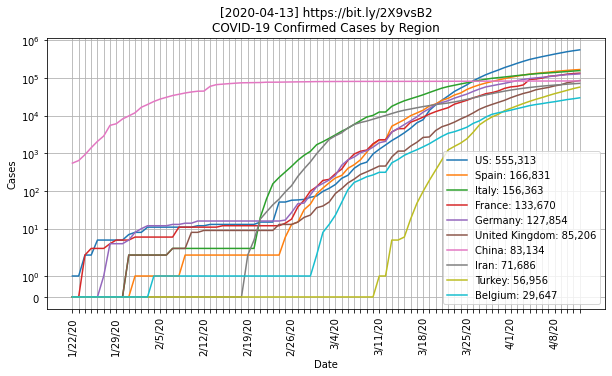

In [8]:
ts_confirmed_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

ts_only_confirmed_df = ts_confirmed_df.drop(["Lat", "Long"], axis=1).groupby("Country/Region").sum().sort_values(list(ts_confirmed_df)[-1], ascending=False)

plt.figure(figsize=(10, 5))

ax = plt.subplot()


plt.title(f"[{date.today()}] https://bit.ly/2X9vsB2\nCOVID-19 Confirmed Cases by Region")

ax.grid(which="major")
plt.xticks(rotation="vertical")

legend_size = 10

for region in ts_only_confirmed_df.index[:legend_size]:
  ax.plot(ts_only_confirmed_df.loc[region], label=f"{region}: {ts_only_confirmed_df.loc[region][-1]:,}")

ax.legend()
plt.yscale("symlog")
plt.ylabel("Cases")
plt.xlabel("Date")

i = 0
for label in ax.xaxis.get_ticklabels():
  if i % 7 != 0:
    label.set_visible(False)
  i += 1

plt.show()

### Projections

In [9]:
ts_global_confirmed_df = ts_confirmed_df.drop(["Lat", "Long"], axis=1).sum()[1:]

ts_global_confirmed_df

1/22/20        555
1/23/20        654
1/24/20        941
1/25/20       1434
1/26/20       2118
            ...   
4/8/20     1511104
4/9/20     1595350
4/10/20    1691719
4/11/20    1771514
4/12/20    1846679
Length: 82, dtype: object

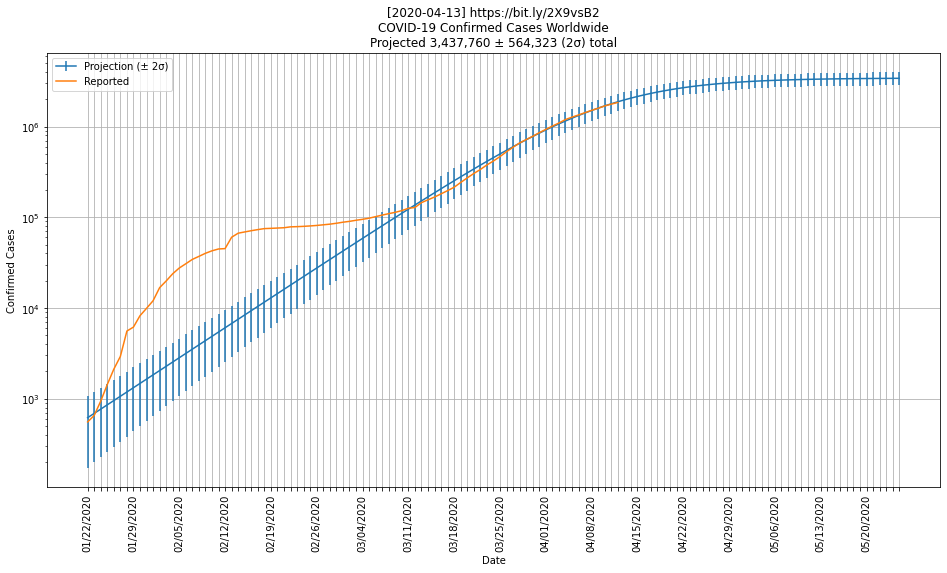

In [10]:
u_popt = fit_growth(sigmoid, *zip(*enumerate(ts_global_confirmed_df)))

if u_popt is not None:
  curve = lambda x: usigmoid(x, *u_popt)

# Prediction.
fig, ax = plt.subplots(1, figsize=(16, 8))

days_to_plot = 125

if u_popt is not None:
  u_ys = [curve(x) for x in range(days_to_plot)]
  ax.errorbar(x=range(len(u_ys)), y=[u_y.nominal_value for u_y in u_ys], yerr=[u_y.std_dev * 2 for u_y in u_ys], label="Projection (± 2σ)")
ax.errorbar(x=range(ts_global_confirmed_df.size), y=ts_global_confirmed_df, label="Reported")

ax.set_title(f"[{date.today()}] https://bit.ly/2X9vsB2\nCOVID-19 Confirmed Cases Worldwide\n{'Projection unavailable' if u_popt is None else f'Projected {int(u_popt[1].nominal_value):,} ± {int(u_popt[1].std_dev * 2):,} (2σ) total'}")

day_zero = datetime(2020, 1, 22, 0, 0)

ax.set_xticks(range(days_to_plot))
ax.set_xticklabels([(day_zero + timedelta(days=x)).strftime("%m/%d/%Y") for x in range(days_to_plot)])

plt.setp(ax.get_xmajorticklabels(), rotation=90)

i = 0
for label in ax.get_xmajorticklabels():
  if i % 7 != 0:
    label.set_visible(False)
  i += 1

ax.grid()
ax.legend()
ax.set_yscale("log")

ax.set_xlabel("Date")
ax.set_ylabel("Confirmed Cases")

plt.show()

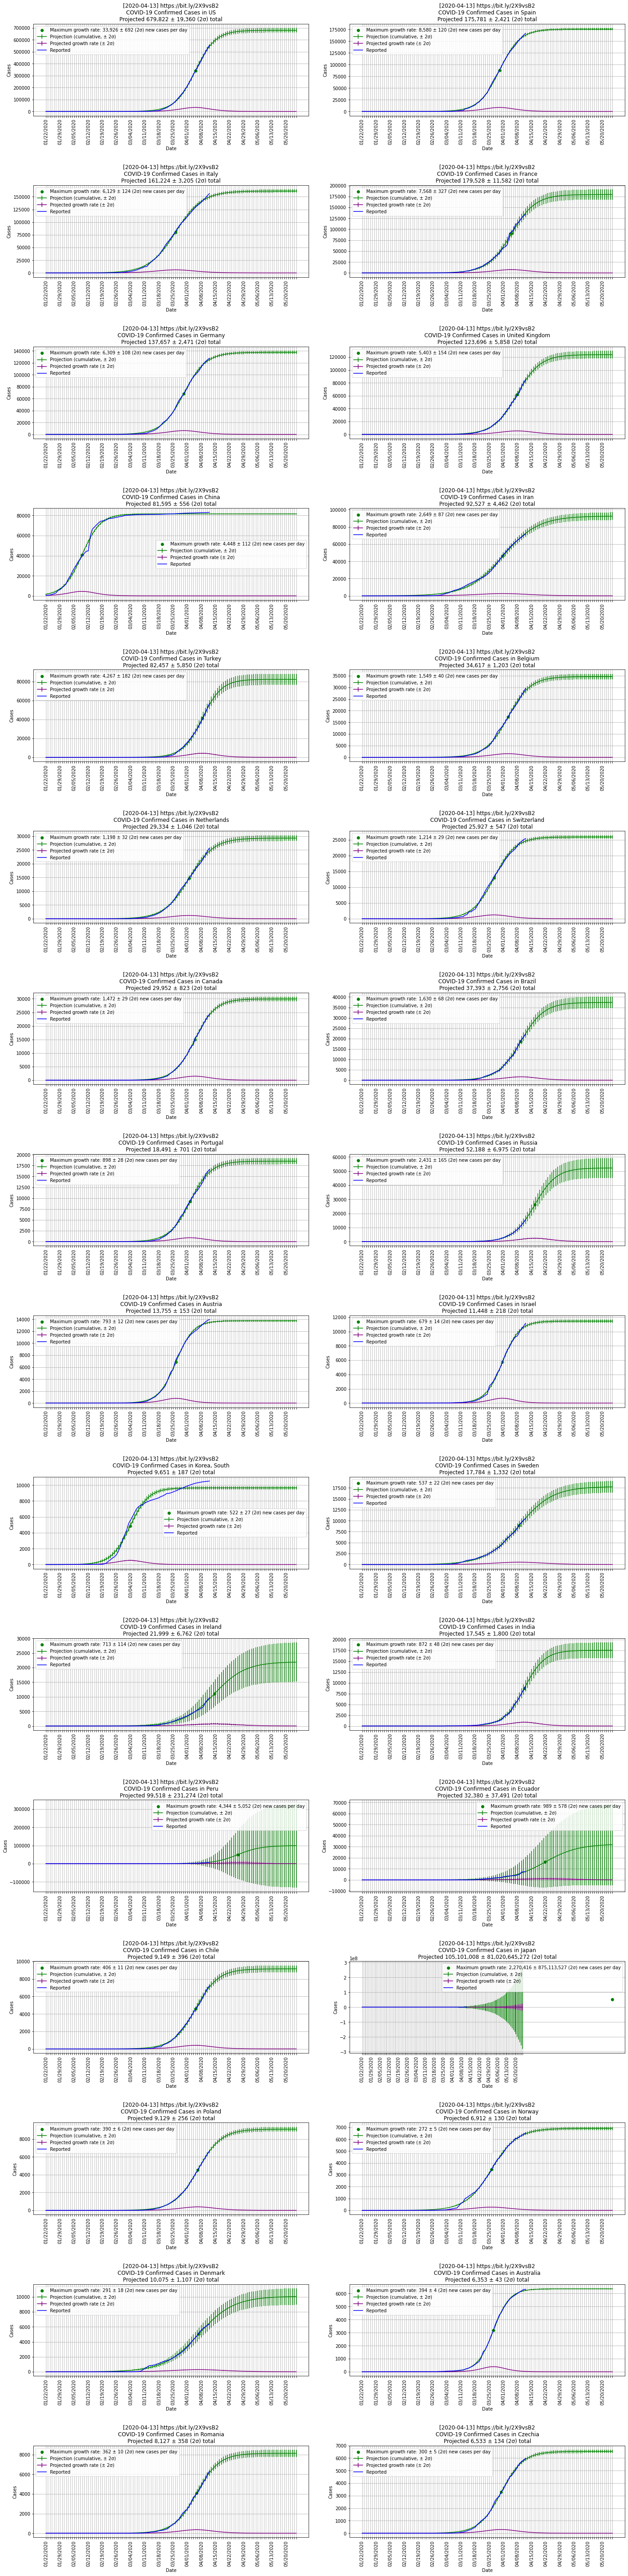

In [11]:
plot_top_n_countries = 32

columns = 2
scaling = 10, 5

ts_plot_df = ts_only_confirmed_df[:min(plot_top_n_countries, len(ts_only_confirmed_df))]

rows = math.ceil(len(ts_plot_df)/columns)
fig, axs = plt.subplots(rows, columns,
                        figsize=(columns * scaling[0], rows * scaling[1]))

subplot = 0
for region in ts_plot_df.index:
  current_ax = axs[math.floor(subplot/columns), subplot % columns]
  subplot += 1

  regional_ts = ts_plot_df.loc[region]

  xs, ys = zip(*enumerate(regional_ts))
  u_popt = fit_growth(sigmoid, xs, ys)

  if u_popt is not None:
    curve = lambda x: usigmoid(x, *u_popt)
    curve_derivative = lambda x: usigmoid_derivative(x, *u_popt)

  current_ax.set_title(f"[{date.today()}] https://bit.ly/2X9vsB2\nCOVID-19 Confirmed Cases in {region}\n{'Projection unavailable' if u_popt is None else f'Projected {int(u_popt[1].nominal_value):,} ± {int(u_popt[1].std_dev * 2):,} (2σ) total'}")
  current_ax.set_ylabel("Cases")
  current_ax.set_xlabel("Date")

  days_to_plot = 125

  if u_popt is not None:
    u_ys = [curve(day) for day in range(days_to_plot)]
    current_ax.errorbar(x=range(days_to_plot), y=[u_y.nominal_value for u_y in u_ys], yerr=[u_y.std_dev * 2 for u_y in u_ys], label="Projection (cumulative, ± 2σ)", color="green")
    u_ys_prime = [curve_derivative(day) for day in range(days_to_plot)]
    current_ax.errorbar(x=range(days_to_plot), y=[u_y_prime.nominal_value for u_y_prime in u_ys_prime], yerr=[u_y_prime.std_dev * 2 for u_y_prime in u_ys_prime], label="Projected growth rate (± 2σ)", color="purple")
    inflection_y = sigmoidal_max_daily_growth_rate(*u_popt)
    current_ax.scatter(x=u_popt[0].nominal_value, y=sigmoid(u_popt[0].nominal_value, *[p.nominal_value for p in u_popt]), label=f"Maximum growth rate: {int(inflection_y.nominal_value):,} ± {int(inflection_y.std_dev):,} (2σ) new cases per day", color="green")

  current_ax.errorbar(x=range(len(regional_ts)), y=regional_ts, label="Reported", color="blue")

  plt.setp(current_ax.get_xmajorticklabels(), rotation=90)

  day_zero = datetime(2020, 1, 22, 0, 0)

  current_ax.set_xticks(range(days_to_plot))
  current_ax.set_xticklabels([(day_zero + timedelta(days=x)).strftime("%m/%d/%Y") for x in range(days_to_plot)])

  i = 0
  for label in current_ax.get_xmajorticklabels():
    if i % 7 != 0:
      label.set_visible(False)
    i += 1

  current_ax.grid()
  current_ax.legend()

fig.tight_layout(pad=3)

plt.show()

## By United States state / territory

In [12]:
ts_us_confirmed_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv")

ts_us_confirmed_df = ts_us_confirmed_df.drop(["UID", "iso2", "iso3", "code3",
                                              "FIPS", "Admin2",
                                              "Country_Region", "Lat", "Long_",
                                              "Combined_Key"], axis=1).groupby("Province_State").sum().sort_values(list(ts_us_confirmed_df)[-1], ascending=False)

ts_us_confirmed_df

1/22/20  1/23/20  1/24/20  ...  4/10/20  4/11/20  4/12/20
Province_State                                       ...                           
New York                        0        0        0  ...   172348   181026   189033
New Jersey                      0        0        0  ...    54588    58151    61850
Massachusetts                   0        0        0  ...    20974    22860    25475
Michigan                        0        0        0  ...    22434    23605    24244
Pennsylvania                    0        0        0  ...    20051    21719    22938
California                      0        0        0  ...    21081    21706    22795
Illinois                        0        0        1  ...    17887    19180    20852
Louisiana                       0        0        0  ...    19253    20014    20595
Florida                         0        0        0  ...    17531    18494    19895
Texas                           0        0        0  ...    12105    13023    13677
Georgia                         0        0        0  ...    11485    12159    12452
Connecticut                     0        0        0  ...    10538    11510    12035
Washington                      1        1        1  ...    10119    10434    10609
Maryland                        0        0        0  ...     6968     7694     8225
Indiana                         0        0        0  ...     6907     7435     7928
Colorado                        0        0        0  ...     6202     6513     7307
Ohio                            0        0        0  ...     5878     6250     6604
Tennessee                       0        0        0  ...     4891     5132     5508
Virginia                        0        0        0  ...     4509     5077     5274
North Carolina                  0        0        0  ...     3965     4354     4570
Missouri                        0        0        0  ...     3897     4108     4269
Alabama                         0        0        0  ...     2947     3217     3563
Arizona                         0        0        0  ...     3112     3393     3542
Wisconsin                       0        0        0  ...     3068     3213     3341
South Carolina                  0        0        0  ...     3067     3211     3320
Nevada                          0        0        0  ...     2722     2702     2836
Mississippi                     0        0        0  ...     2469     2642     2781
Rhode Island                    0        0        0  ...     1727     2349     2665
Utah                            0        0        0  ...     2103     2207     2299
Oklahoma                        0        0        0  ...     1794     1868     1970
Kentucky                        0        0        0  ...     1693     1693     1963
District of Columbia            0        0        0  ...     1660     1778     1875
Delaware                        0        0        0  ...     1326     1479     1625
Minnesota                       0        0        0  ...     1336     1427     1621
Iowa                            0        0        0  ...     1388     1510     1587
Oregon                          0        0        0  ...     1322     1371     1527
Idaho                           0        0        0  ...     1354     1396     1407
Kansas                          0        0        0  ...     1117     1275     1344
Arkansas                        0        0        0  ...     1171     1228     1280
New Mexico                      0        0        0  ...     1081     1091     1245
New Hampshire                   0        0        0  ...      819      885      929
Puerto Rico                     0        0        0  ...      725      788      897
Nebraska                        0        0        0  ...      635      699      791
South Dakota                    0        0        0  ...      536      626      730
Vermont                         0        0        0  ...      679      711      727
Maine                           0        0        0  ...      586      616    

### Projections

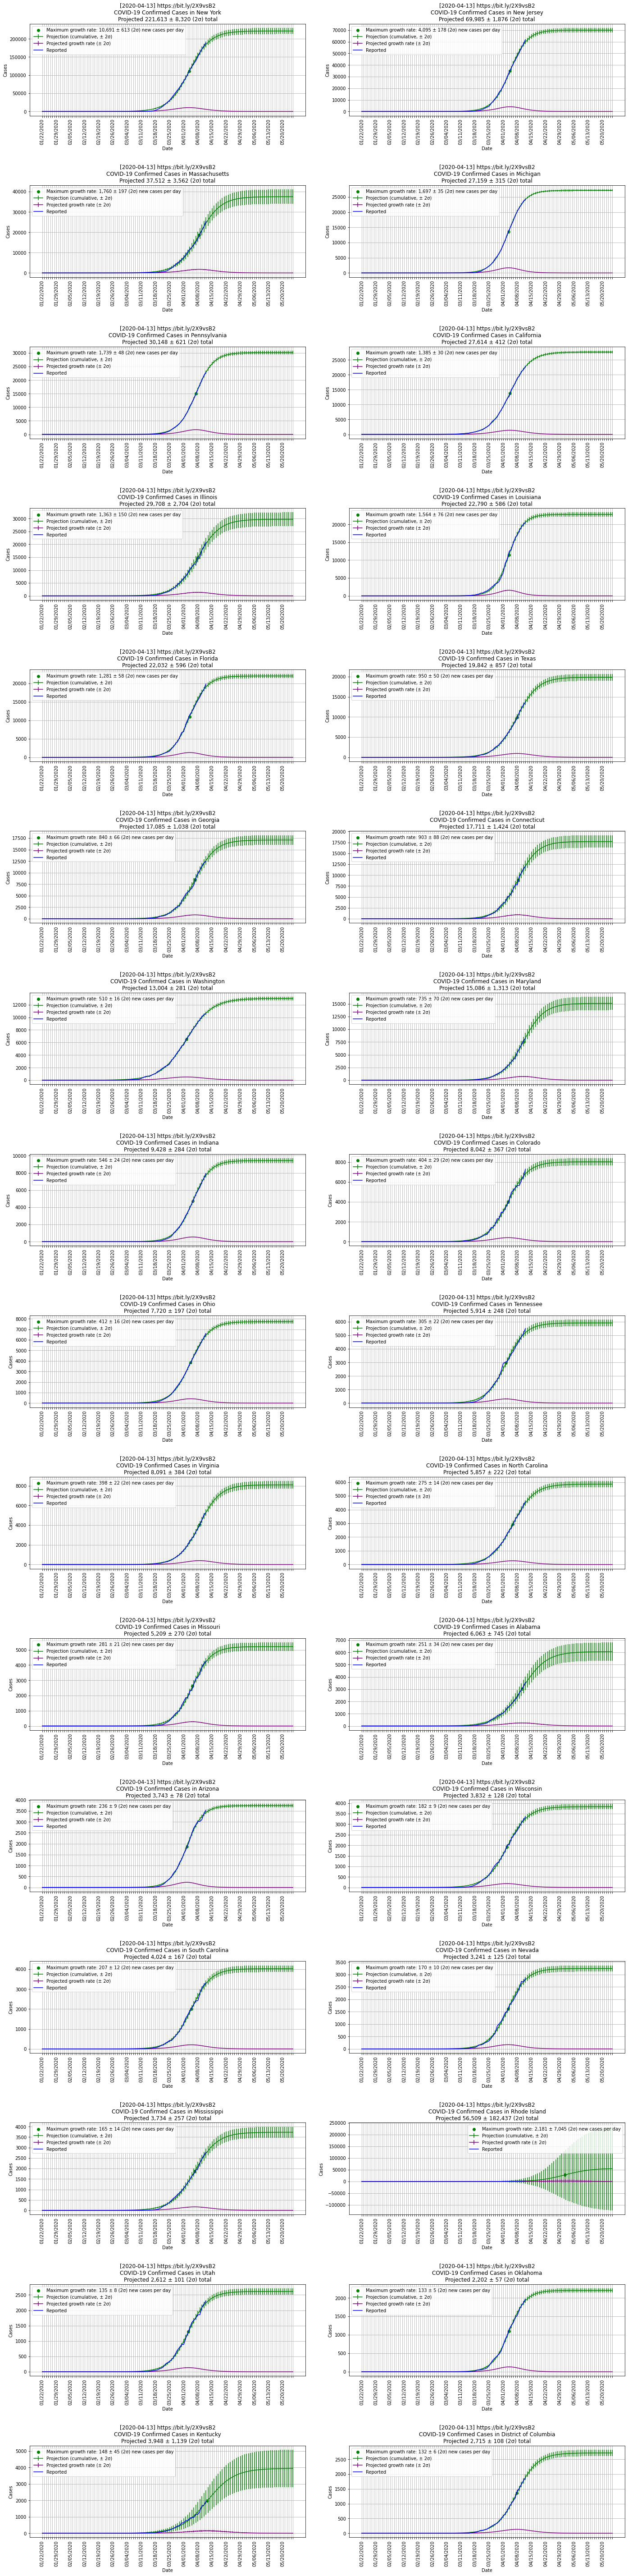

In [13]:
plot_top_n_states = 32

columns = 2
scaling = 10, 5

ts_plot_df = ts_us_confirmed_df[:min(plot_top_n_states, len(ts_us_confirmed_df))]

rows = math.ceil(len(ts_plot_df)/columns)
fig, axs = plt.subplots(rows, columns,
                        figsize=(columns * scaling[0], rows * scaling[1]))

subplot = 0
for region in ts_plot_df.index:
  current_ax = axs[math.floor(subplot/columns), subplot % columns]
  subplot += 1

  regional_ts = ts_plot_df.loc[region]

  xs, ys = zip(*enumerate(regional_ts))
  u_popt = fit_growth(sigmoid, xs, ys)

  if u_popt is not None:
    curve = lambda x: usigmoid(x, *u_popt)
    curve_derivative = lambda x: usigmoid_derivative(x, *u_popt)

  current_ax.set_title(f"[{date.today()}] https://bit.ly/2X9vsB2\nCOVID-19 Confirmed Cases in {region}\n{'Projection unavailable' if u_popt is None else f'Projected {int(u_popt[1].nominal_value):,} ± {int(u_popt[1].std_dev * 2):,} (2σ) total'}")
  current_ax.set_ylabel("Cases")
  current_ax.set_xlabel("Date")

  days_to_plot = 125

  if u_popt is not None:
    u_ys = [curve(day) for day in range(days_to_plot)]
    current_ax.errorbar(x=range(days_to_plot), y=[u_y.nominal_value for u_y in u_ys], yerr=[u_y.std_dev * 2 for u_y in u_ys], label="Projection (cumulative, ± 2σ)", color="green")
    u_ys_prime = [curve_derivative(day) for day in range(days_to_plot)]
    current_ax.errorbar(x=range(days_to_plot), y=[u_y_prime.nominal_value for u_y_prime in u_ys_prime], yerr=[u_y_prime.std_dev * 2 for u_y_prime in u_ys_prime], label="Projected growth rate (± 2σ)", color="purple")
    inflection_y = sigmoidal_max_daily_growth_rate(*u_popt)
    current_ax.scatter(x=u_popt[0].nominal_value, y=sigmoid(u_popt[0].nominal_value, *[p.nominal_value for p in u_popt]), label=f"Maximum growth rate: {int(inflection_y.nominal_value):,} ± {int(inflection_y.std_dev * 2):,} (2σ) new cases per day", color="green")

  current_ax.errorbar(x=range(len(regional_ts)), y=regional_ts, label="Reported", color="blue")

  plt.setp(current_ax.get_xmajorticklabels(), rotation=90)

  day_zero = datetime(2020, 1, 22, 0, 0)

  current_ax.set_xticks(range(days_to_plot))
  current_ax.set_xticklabels([(day_zero + timedelta(days=x)).strftime("%m/%d/%Y") for x in range(days_to_plot)])

  i = 0
  for label in current_ax.get_xmajorticklabels():
    if i % 7 != 0:
      label.set_visible(False)
    i += 1

  current_ax.grid()
  current_ax.legend()

fig.tight_layout(pad=3)

plt.show()

# Deaths

## By Country

### Aggregated

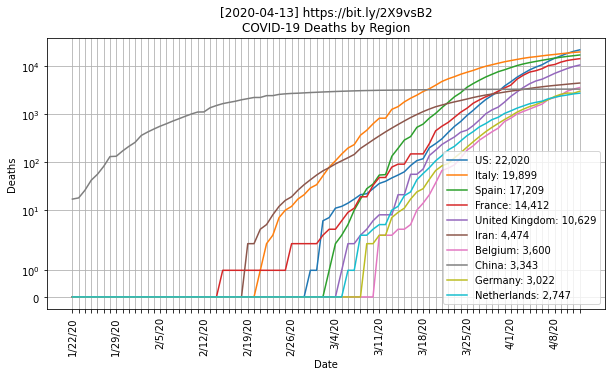

In [14]:
ts_deaths_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")

ts_only_deaths_df = ts_deaths_df.drop(["Lat", "Long"], axis=1).groupby("Country/Region").sum().sort_values(list(ts_deaths_df)[-1], ascending=False)

plt.figure(figsize=(10, 5))

ax = plt.subplot()


plt.title(f"[{date.today()}] https://bit.ly/2X9vsB2\nCOVID-19 Deaths by Region")

ax.grid(which="major")
plt.xticks(rotation="vertical")

legend_size = 10

for region in ts_only_deaths_df.index[:legend_size]:
  ax.plot(ts_only_deaths_df.loc[region], label=f"{region}: {ts_only_deaths_df.loc[region][-1]:,}")

ax.legend()
plt.yscale("symlog")
plt.ylabel("Deaths")
plt.xlabel("Date")

i = 0
for label in ax.xaxis.get_ticklabels():
  if i % 7 != 0:
    label.set_visible(False)
  i += 1

plt.show()

### Projections

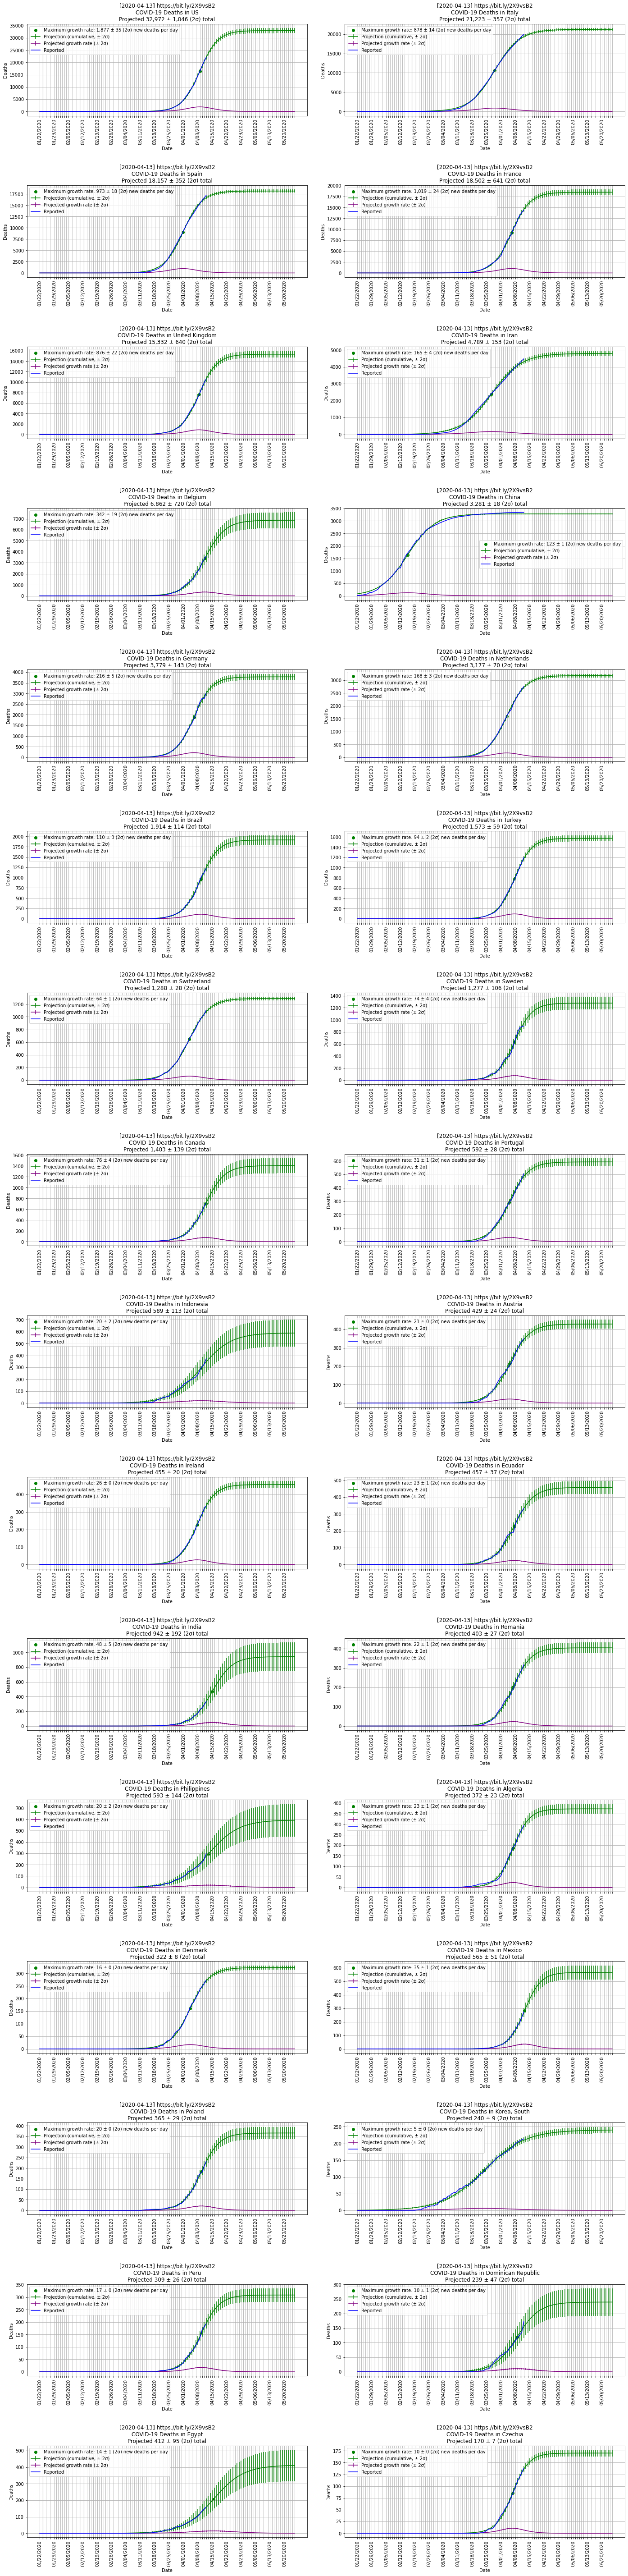

In [15]:
plot_top_n_countries = 32

columns = 2
scaling = 10, 5

ts_plot_df = ts_only_deaths_df[:min(plot_top_n_countries, len(ts_only_deaths_df))]

rows = math.ceil(len(ts_plot_df)/columns)
fig, axs = plt.subplots(rows, columns,
                        figsize=(columns * scaling[0], rows * scaling[1]))

subplot = 0
for region in ts_plot_df.index:
  current_ax = axs[math.floor(subplot/columns), subplot % columns]
  subplot += 1

  regional_ts = ts_plot_df.loc[region]

  xs, ys = zip(*enumerate(regional_ts))
  u_popt = fit_growth(sigmoid, xs, ys)
  
  if u_popt is not None:
    curve = lambda x: usigmoid(x, *u_popt)
    curve_derivative = lambda x: usigmoid_derivative(x, *u_popt)

  current_ax.set_title(f"[{date.today()}] https://bit.ly/2X9vsB2\nCOVID-19 Deaths in {region}\n{'Projection unavailable' if u_popt is None else f'Projected {int(u_popt[1].nominal_value):,} ± {int(u_popt[1].std_dev * 2):,} (2σ) total'}")
  current_ax.set_ylabel("Deaths")
  current_ax.set_xlabel("Date")

  days_to_plot = 125

  if u_popt is not None:
    u_ys = [curve(x) for x in range(days_to_plot)]
    current_ax.errorbar(x=range(days_to_plot), y=[u_y.nominal_value for u_y in u_ys], yerr=[u_y.std_dev * 2 for u_y in u_ys], label="Projection (cumulative, ± 2σ)", color="green")
    u_ys_prime = [curve_derivative(x) for x in range(days_to_plot)]
    current_ax.errorbar(x=range(days_to_plot), y=[u_y_prime.nominal_value for u_y_prime in u_ys_prime], yerr=[u_y_prime.std_dev * 2 for u_y_prime in u_ys_prime], label="Projected growth rate (± 2σ)", color="purple")
    inflection_y = sigmoidal_max_daily_growth_rate(*u_popt)
    current_ax.scatter(x=u_popt[0].nominal_value, y=sigmoid(u_popt[0].nominal_value, *[p.nominal_value for p in u_popt]), label=f"Maximum growth rate: {int(inflection_y.nominal_value):,} ± {int(inflection_y.std_dev):,} (2σ) new deaths per day", color="green")

  current_ax.errorbar(x=range(len(regional_ts)), y=regional_ts, label="Reported", color="blue")

  plt.setp(current_ax.get_xmajorticklabels(), rotation=90)

  day_zero = datetime(2020, 1, 22, 0, 0)

  current_ax.set_xticks(range(days_to_plot))
  current_ax.set_xticklabels([(day_zero + timedelta(days=x)).strftime("%m/%d/%Y") for x in range(days_to_plot)])

  i = 0
  for label in current_ax.get_xmajorticklabels():
    if i % 7 != 0:
      label.set_visible(False)
    i += 1

  current_ax.grid()
  current_ax.legend()

fig.tight_layout(pad=3)

plt.show()

## By United States state / territory

In [16]:
ts_us_deaths_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv")

ts_us_deaths_df = ts_us_deaths_df.drop(["UID", "iso2", "iso3", "code3",
                                           "FIPS", "Admin2",
                                           "Country_Region", "Lat", "Long_",
                                           "Combined_Key", "Population"], axis=1).groupby("Province_State").sum().sort_values(list(ts_us_confirmed_df)[-1], ascending=False)

ts_us_deaths_df

1/22/20  1/23/20  1/24/20  ...  4/10/20  4/11/20  4/12/20
Province_State                                       ...                           
New York                        0        0        0  ...     7867     8627     9385
New Jersey                      0        0        0  ...     1932     2183     2350
Michigan                        0        0        0  ...     1276     1384     1479
Louisiana                       0        0        0  ...      755      806      840
Massachusetts                   0        0        0  ...      599      686      756
Illinois                        0        0        0  ...      597      677      720
California                      0        0        0  ...      583      605      641
Pennsylvania                    0        0        0  ...      418      503      557
Connecticut                     0        0        0  ...      448      494      554
Washington                      0        0        0  ...      483      495      506
Florida                         0        0        0  ...      390      438      461
Georgia                         0        0        0  ...      416      429      433
Indiana                         0        0        0  ...      300      330      343
Colorado                        0        0        0  ...      226      250      289
Texas                           0        0        0  ...      238      266      283
Ohio                            0        0        0  ...      231      247      253
Maryland                        0        0        0  ...      171      206      236
Wisconsin                       0        0        0  ...      128      137      144
Virginia                        0        0        0  ...      121      130      141
Missouri                        0        0        0  ...       99      116      118
Arizona                         0        0        0  ...       97      108      115
Nevada                          0        0        0  ...       90      102      112
Tennessee                       0        0        0  ...       98      106      106
Kentucky                        0        0        0  ...       90       90       97
Oklahoma                        0        0        0  ...       88       94       96
Mississippi                     0        0        0  ...       82       93       96
Alabama                         0        0        0  ...       80       92       93
North Carolina                  0        0        0  ...       83       89       89
South Carolina                  0        0        0  ...       72       80       82
Minnesota                       0        0        0  ...       57       64       70
Rhode Island                    0        0        0  ...       43       56       63
Kansas                          0        0        0  ...       42       55       56
Oregon                          0        0        0  ...       44       48       52
District of Columbia            0        0        0  ...       38       47       50
Puerto Rico                     0        0        0  ...       39       42       44
Iowa                            0        0        0  ...       31       34       41
Delaware                        0        0        0  ...       32       33       35
Idaho                           0        0        0  ...       24       25       27
Arkansas                        0        0        0  ...       21       25       27
Vermont                         0        0        0  ...       24       25       27
New Mexico                      0        0        0  ...       17       19       26
New Hampshire                   0        0        0  ...       21       22       23
Maine                           0        0        0  ...       17       19       19
Nebraska                        0        0        0  ...       15       17       17
Utah                            0        0        0  ...       13       13       13
Hawaii                          0        0        0  ...        6        8    

### Projections

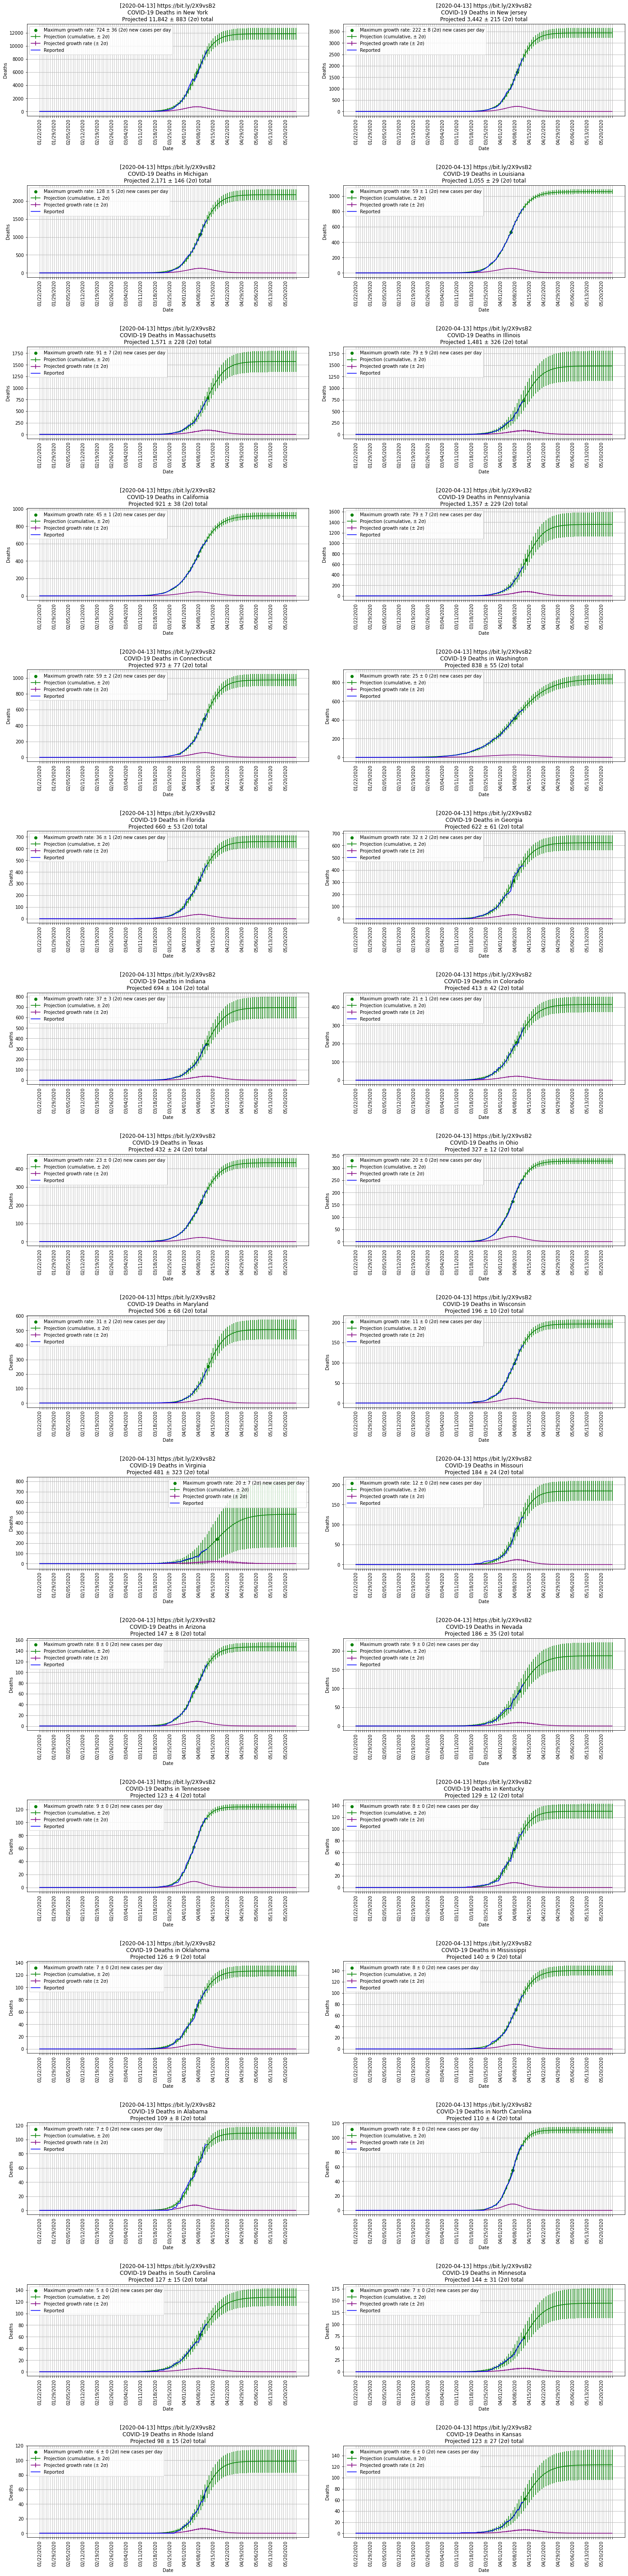

In [17]:
plot_top_n_states = 32

columns = 2
scaling = 10, 5

ts_plot_df = ts_us_deaths_df[:min(plot_top_n_states, len(ts_us_deaths_df))]

rows = math.ceil(len(ts_plot_df)/columns)
fig, axs = plt.subplots(rows, columns,
                        figsize=(columns * scaling[0], rows * scaling[1]))

subplot = 0
for region in ts_plot_df.index:
  current_ax = axs[math.floor(subplot/columns), subplot % columns]
  subplot += 1

  regional_ts = ts_plot_df.loc[region]

  xs, ys = zip(*enumerate(regional_ts))
  u_popt = fit_growth(sigmoid, xs, ys)

  if u_popt is not None:
    curve = lambda x: usigmoid(x, *u_popt)
    curve_derivative = lambda x: usigmoid_derivative(x, *u_popt)

  current_ax.set_title(f"[{date.today()}] https://bit.ly/2X9vsB2\nCOVID-19 Deaths in {region}\n{'Projection unavailable' if u_popt is None else f'Projected {int(u_popt[1].nominal_value):,} ± {int(u_popt[1].std_dev * 2):,} (2σ) total'}")
  current_ax.set_ylabel("Deaths")
  current_ax.set_xlabel("Date")

  days_to_plot = 125

  if u_popt is not None:
    u_ys = [curve(day) for day in range(days_to_plot)]
    current_ax.errorbar(x=range(days_to_plot), y=[u_y.nominal_value for u_y in u_ys], yerr=[u_y.std_dev * 2 for u_y in u_ys], label="Projection (cumulative, ± 2σ)", color="green")
    u_ys_prime = [curve_derivative(day) for day in range(days_to_plot)]
    current_ax.errorbar(x=range(days_to_plot), y=[u_y_prime.nominal_value for u_y_prime in u_ys_prime], yerr=[u_y_prime.std_dev * 2 for u_y_prime in u_ys_prime], label="Projected growth rate (± 2σ)", color="purple")
    inflection_y = sigmoidal_max_daily_growth_rate(*u_popt)
    current_ax.scatter(x=u_popt[0].nominal_value, y=sigmoid(u_popt[0].nominal_value, *[p.nominal_value for p in u_popt]), label=f"Maximum growth rate: {int(inflection_y.nominal_value):,} ± {int(inflection_y.std_dev):,} (2σ) new cases per day", color="green")

  current_ax.errorbar(x=range(len(regional_ts)), y=regional_ts, label="Reported", color="blue")

  plt.setp(current_ax.get_xmajorticklabels(), rotation=90)

  day_zero = datetime(2020, 1, 22, 0, 0)

  current_ax.set_xticks(range(days_to_plot))
  current_ax.set_xticklabels([(day_zero + timedelta(days=x)).strftime("%m/%d/%Y") for x in range(days_to_plot)])

  i = 0
  for label in current_ax.get_xmajorticklabels():
    if i % 7 != 0:
      label.set_visible(False)
    i += 1

  current_ax.grid()
  current_ax.legend()

fig.tight_layout(pad=3)

plt.show()

## By Country

### Aggregated

In [18]:
ts_only_consol_deaths_df = ts_deaths_df.drop(["Lat", "Long"], axis=1).sum()[1:]

ts_only_consol_deaths_df

1/22/20        17
1/23/20        18
1/24/20        26
1/25/20        42
1/26/20        56
            ...  
4/8/20      88338
4/9/20      95455
4/10/20    102525
4/11/20    108503
4/12/20    114091
Length: 82, dtype: object

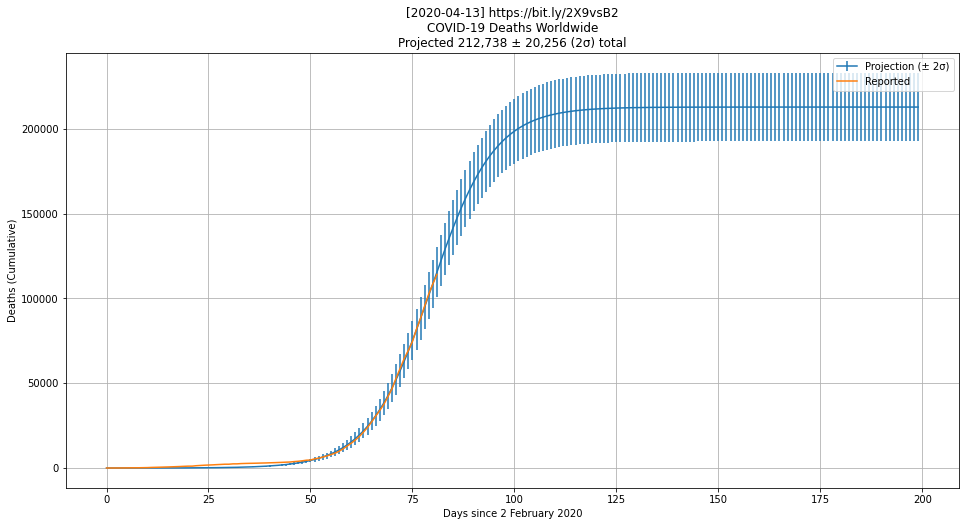

In [19]:
u_popt = fit_growth(sigmoid, *zip(*enumerate(ts_only_consol_deaths_df)))

if u_popt is not None:
  curve = lambda x: usigmoid(x, *u_popt)

# Prediction.
plt.figure(figsize=(16, 8))
if u_popt is not None:
  u_ys = [curve(x) for x in range(200)]
  plt.errorbar(x=range(len(u_ys)), y=[u_y.nominal_value for u_y in u_ys], yerr=[u_y.std_dev * 2 for u_y in u_ys], label="Projection (± 2σ)")
plt.errorbar(x=range(ts_only_consol_deaths_df.size), y=ts_only_consol_deaths_df, label="Reported")

plt.title(f"[{date.today()}] https://bit.ly/2X9vsB2\nCOVID-19 Deaths Worldwide\n{'Projection unavailable' if u_popt is None else f'Projected {int(u_popt[1].nominal_value):,} ± {int(u_popt[1].std_dev * 2):,} (2σ) total'}")
plt.grid()
plt.xlabel("Days since 2 February 2020")
plt.ylabel("Deaths (Cumulative)")
#plt.yscale("symlog")
plt.legend()

plt.show()